### We're going to look for differences in delays between large and small airports in the US.

#### Load the python libraries that you will need for this project 

In [19]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import os
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import seaborn as sns

#### Examine the data 

In [20]:
df_cancellations = pd.read_csv("./assets/airport_cancellations.csv")
df_operations = pd.read_csv("./assets/Airport_operations.csv")
df_airports = pd.read_csv('./assets/airports.csv')

In [21]:
#df_cancellations.head()

In [22]:
#df_operations.head()

#### Merge the data

In [23]:
df_all = pd.merge(df_operations,df_cancellations, how='left',left_on=['airport','year'],right_on=['Airport','Year'],)
df_all = pd.merge(df_all,df_airports, how='left', left_on='airport',right_on='LocID')
print(df_all.shape)
#print(df_all.columns)
#df_all.head(3)

(841, 34)


#### Plot Total Avg Delay vs % on-time Departures to see how they correlate

#### Cluster Airports by flight volume

In [24]:
from sklearn.cluster import KMeans

X = df_all[['arrivals for metric computation','departures for metric computation']]

kmeans = KMeans(n_clusters=4, random_state=2).fit(X)

In [25]:
kmeans.cluster_centers_

array([[  40796.78017241,   40954.625     ],
       [ 237939.99275362,  238836.15217391],
       [ 442945.32      ,  444397.48      ],
       [ 130064.62149533,  130709.89719626]])

In [26]:
df_all['size_label'] = kmeans.labels_

In [27]:
def assign_airport_sizes(series):
    if series == 0:
        return('small')
    if (series ==1):
        return('large')
    if (series == 2):
        return('super-size')
    if series == 3:
        return('medium')

    
df_all['size'] = df_all['size_label'].apply(assign_airport_sizes)

In [28]:
df_all['size'].value_counts()

small         464
medium        214
large         138
super-size     25
Name: size, dtype: int64

In [29]:
print(df_all[df_all['size']=='super-size']['airport'].unique())

['ATL' 'DFW' 'ORD']


### Look at Total Avg Delay by airport size

In [30]:
df_all['Total Avg Delay'] = df_all['average_gate_departure_delay'] + df_all['average taxi out delay'] + df_all['average airport departure delay'] + df_all['average airborne delay'] + df_all['average taxi in delay'] + df_all['average block delay'] + df_all['average gate arrival delay']

In [31]:
avg_delay_by_size_pivot = pd.pivot_table(df_all,values='Total Avg Delay',columns='size',aggfunc='mean')
avg_delay_by_size_pivot = avg_delay_by_size_pivot.sort_values()
avg_delay_by_size_pivot

size
small         52.789483
medium        52.803645
large         62.865435
super-size    69.568800
Name: Total Avg Delay, dtype: float64

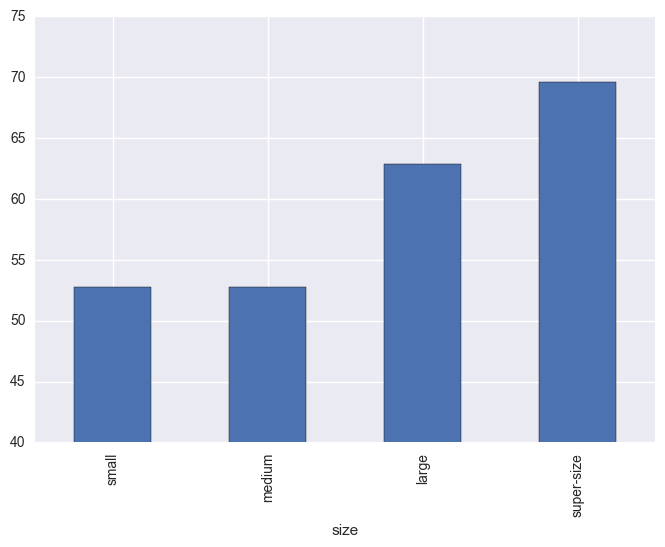

There's 10 minute difference between Medium and Large airports while 
there's a 17 minute difference betwen Medium and Super-Size airports


In [32]:
avg_delay_by_size_pivot.plot(kind='bar',ylim=[40,75])
plt.show()
print("There's 10 minute difference between Medium and Large airports while ")
print("there's a 17 minute difference betwen Medium and Super-Size airports")

#### Explore where the delay difference is coming from

In [33]:
size_departure_delay_type_pivot = pd.pivot_table(df_all,values=['average block delay','average taxi out delay', 'average_gate_departure_delay'],columns='size')
print(size_departure_delay_type_pivot)
print
print
print((6.969-2.307)/17*100, "of total delay discrepancy is accounted for before you even leave the ground")
print("This suggests that the volume of large and super-size airports causes disruption between the gate and take-off")

size                              large     medium      small  super-size
average block delay            3.873478   3.333598   3.116336      4.2908
average taxi out delay         6.363986   3.911495   2.307284      6.9696
average_gate_departure_delay  13.355000  12.643364  13.967026     15.0308


(27.42352941176471, 'of total delay discrepancy is accounted for before you even leave the ground')
This suggests that the volume of large and super-size airports causes disruption between the gate and take-off


In [34]:
size_arrival_delay_type_pivot = pd.pivot_table(df_all,values=['average gate arrival delay','average taxi in delay', 'average airborne delay'],columns='size')
print(size_arrival_delay_type_pivot)


size                            large     medium      small  super-size
average airborne delay       4.005725   3.046636   2.533578      3.0564
average gate arrival delay  14.196014  12.772103  14.445603     15.6032
average taxi in delay        2.406377   1.452336   0.859504      3.7092


#### Conclusions:
       -Most delay time happens at the gate
       -The discrepancy between small and large airport delays can be mitigated by reducing taxi delays

size
super-size    0.643380
large         0.669894
small         0.724146
medium        0.729804
Name: percent on-time airport departures, dtype: float64


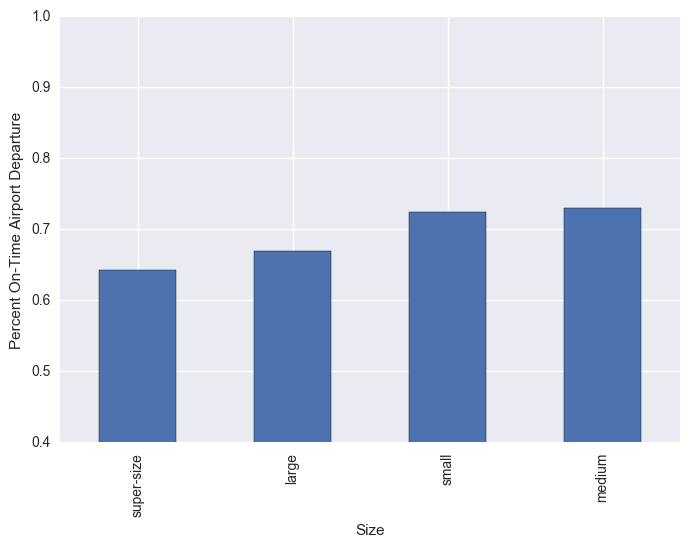

In [35]:
perc_airport_departure_by_size_pivot = pd.pivot_table(df_all,values='percent on-time airport departures',columns='size',aggfunc='mean')
perc_airport_departure_by_size_pivot = perc_airport_departure_by_size_pivot.sort_values()
print(perc_airport_departure_by_size_pivot)
perc_airport_departure_by_size_pivot.plot(kind='bar',ylim=[0.40,1])
plt.xlabel('Size')
plt.ylabel('Percent On-Time Airport Departure')
plt.show()

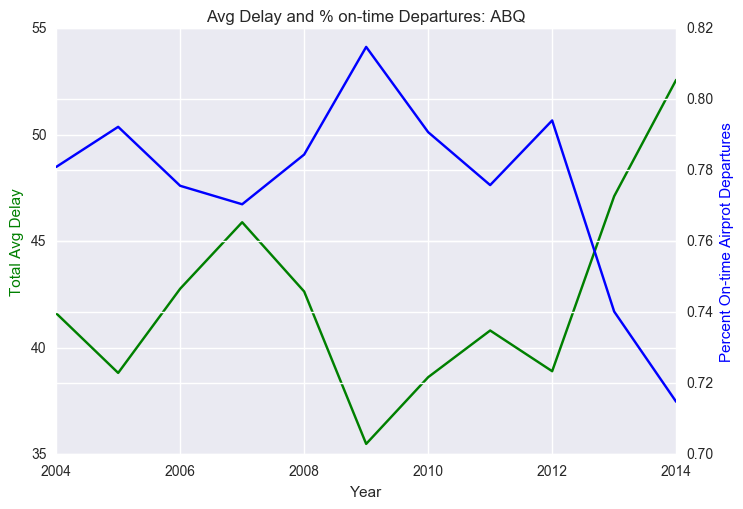

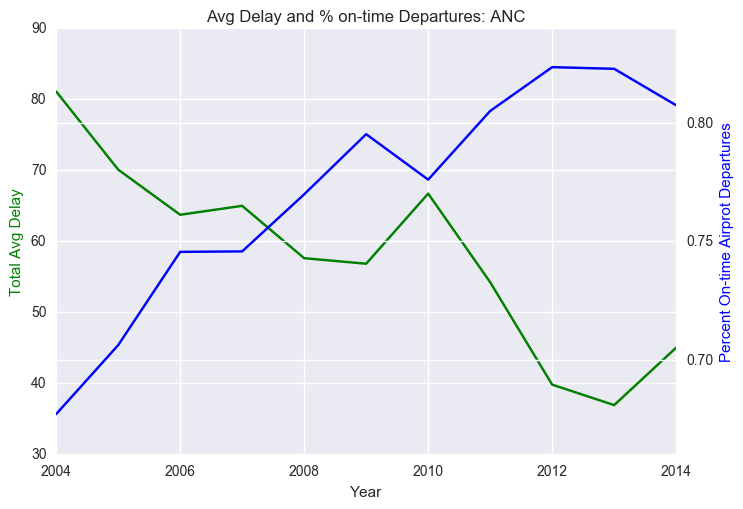

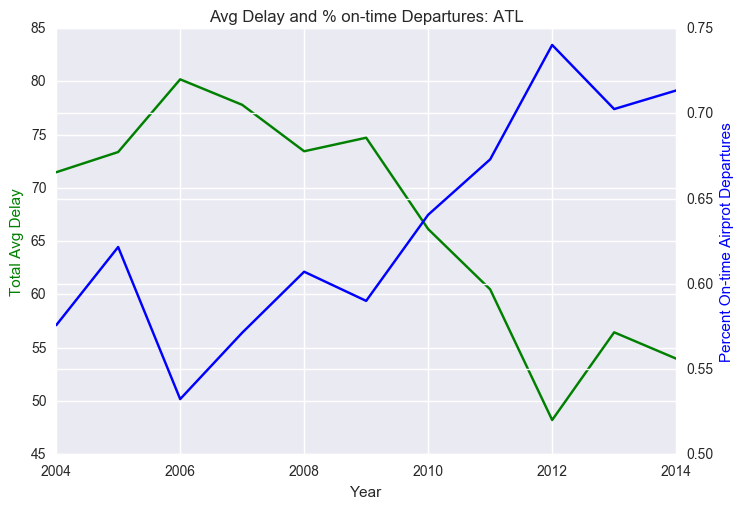

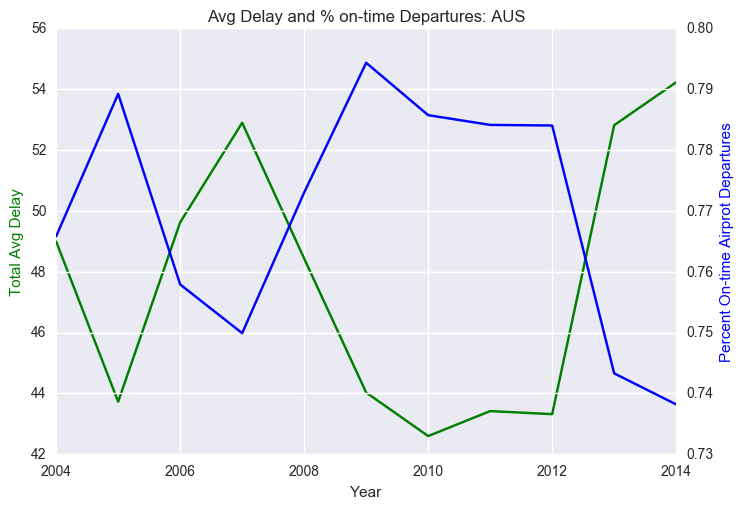

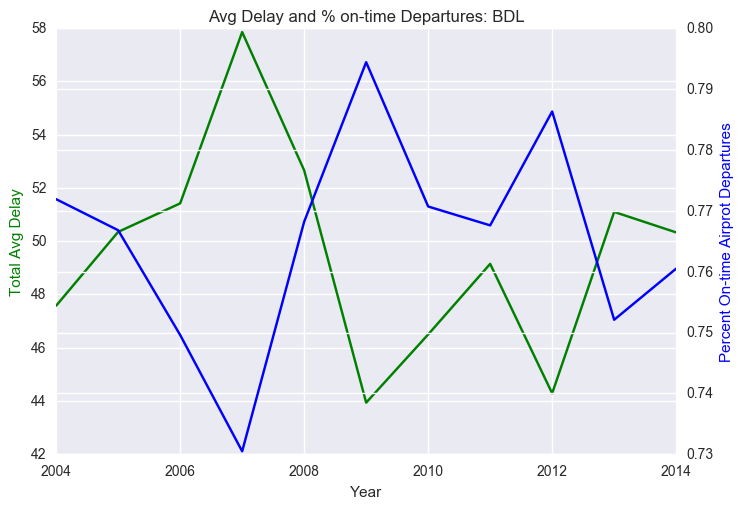

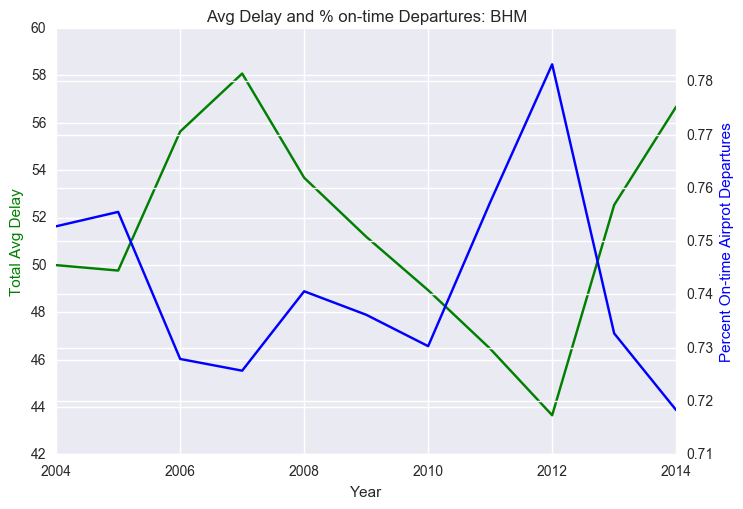

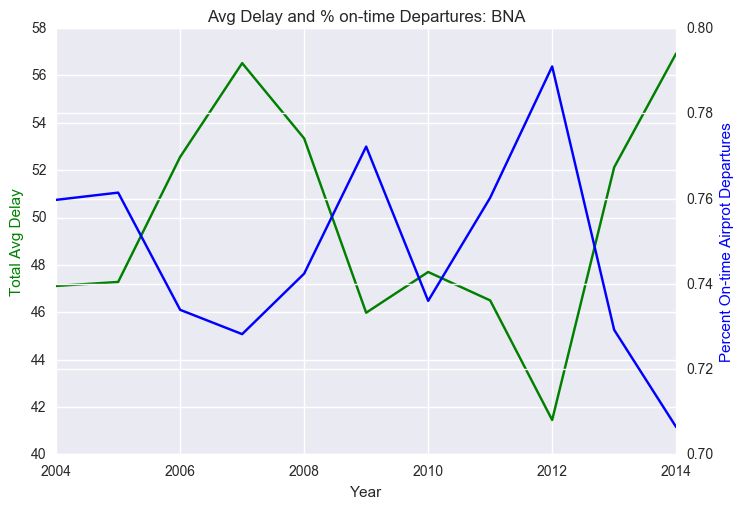

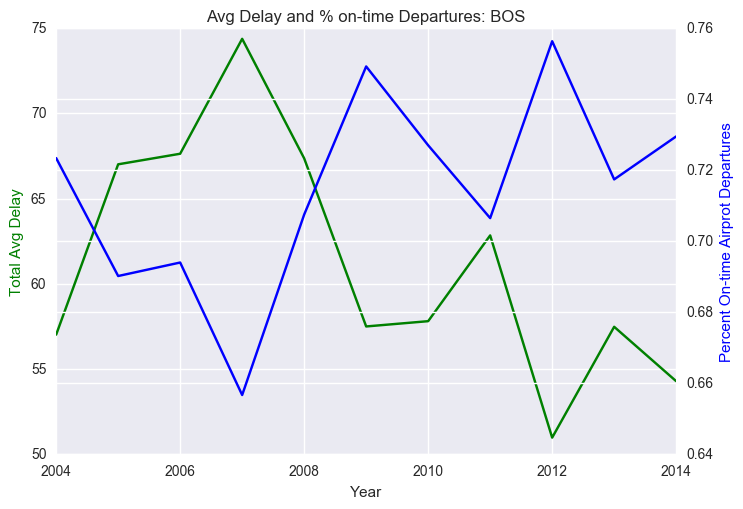

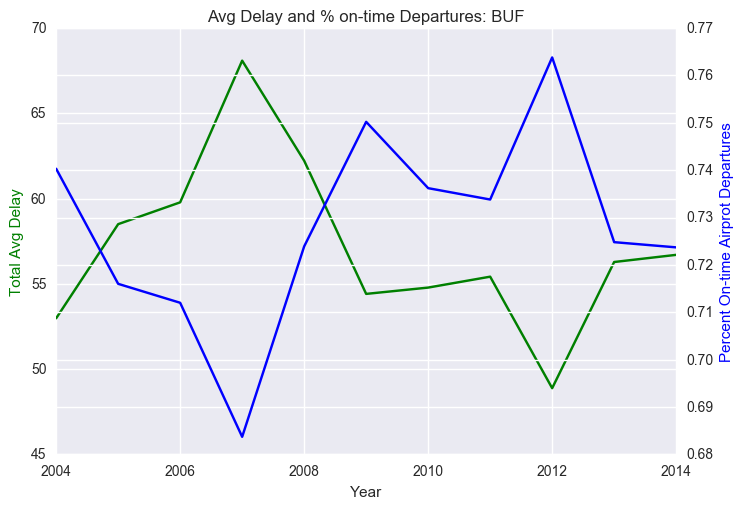

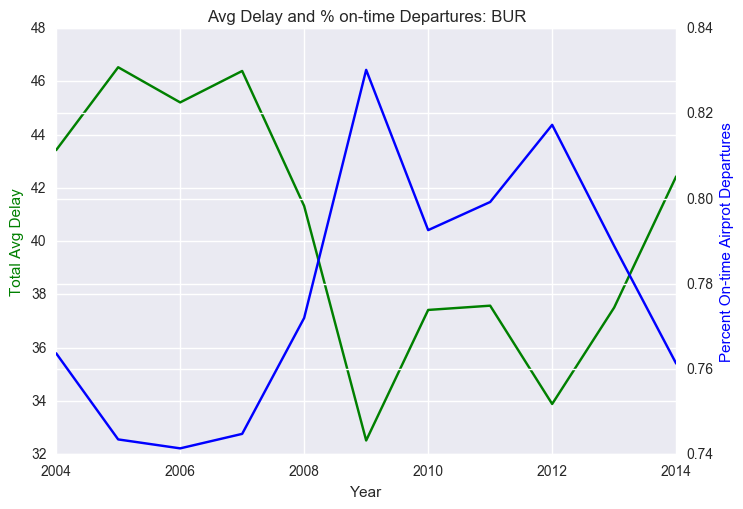

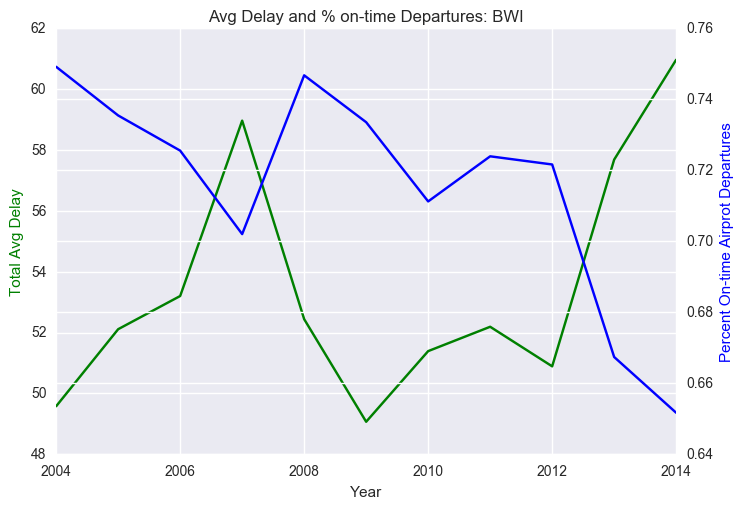

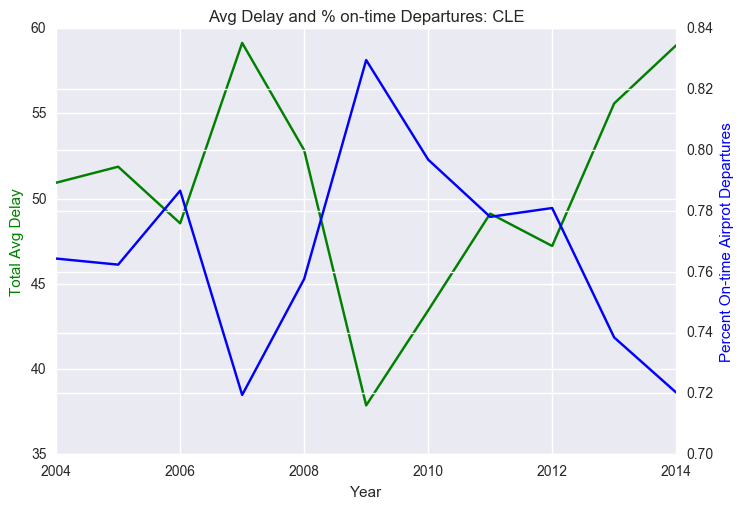

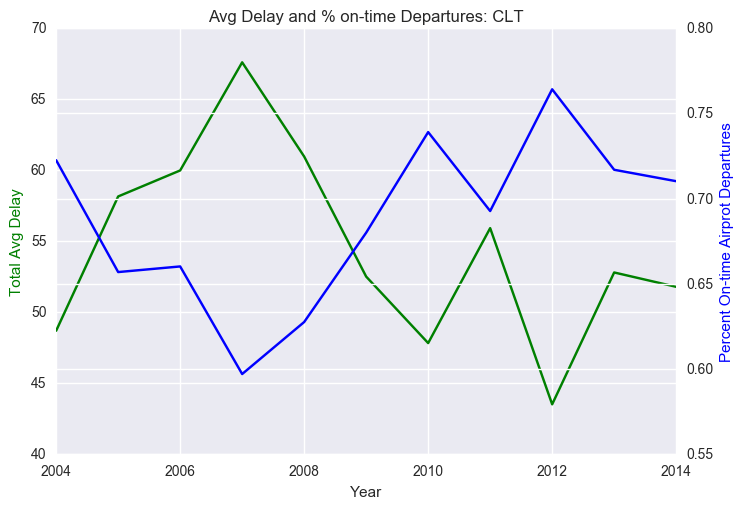

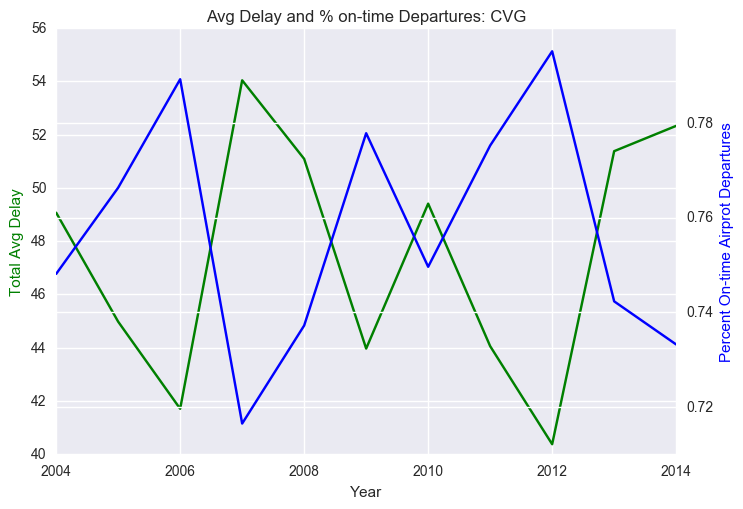

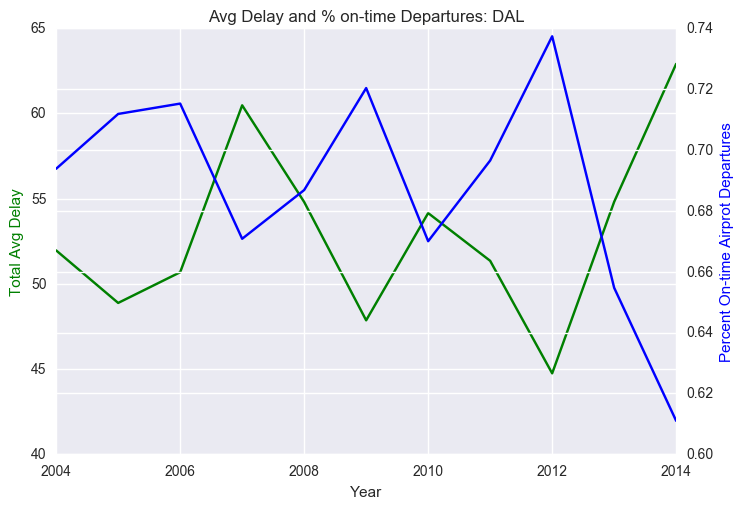

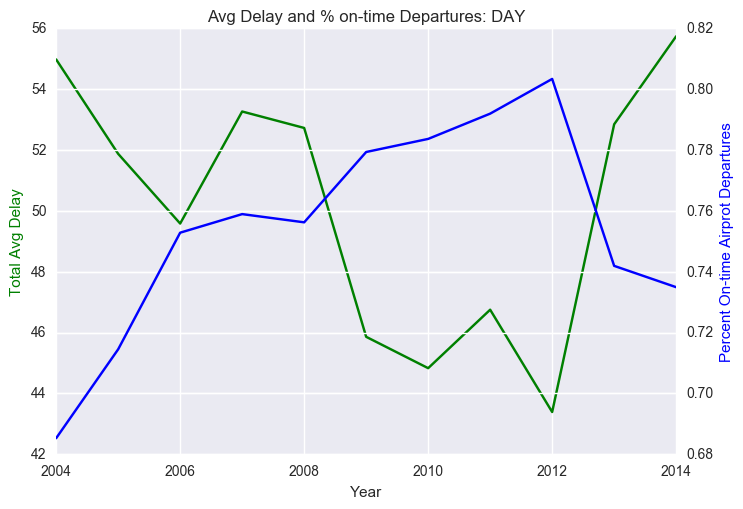

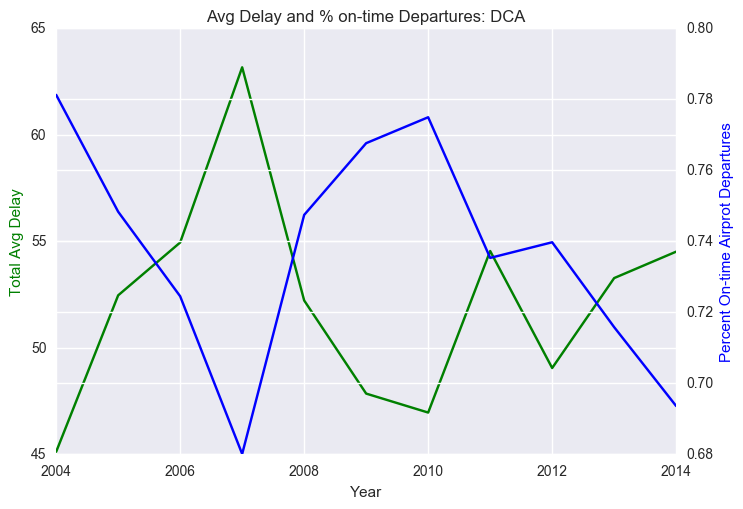

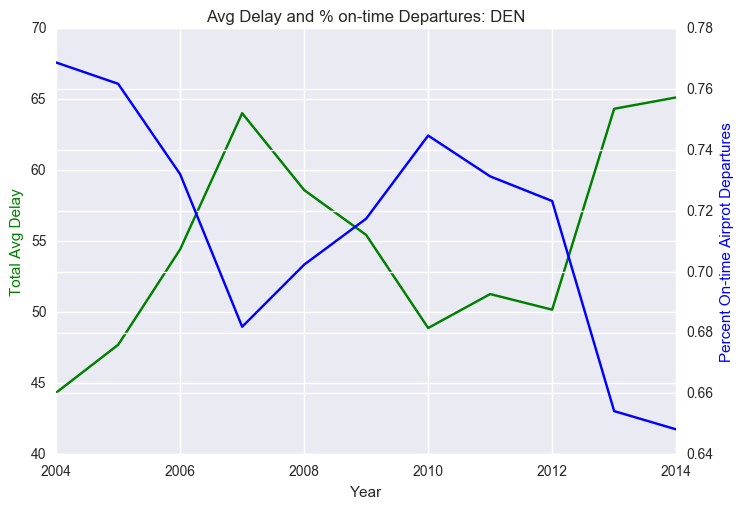

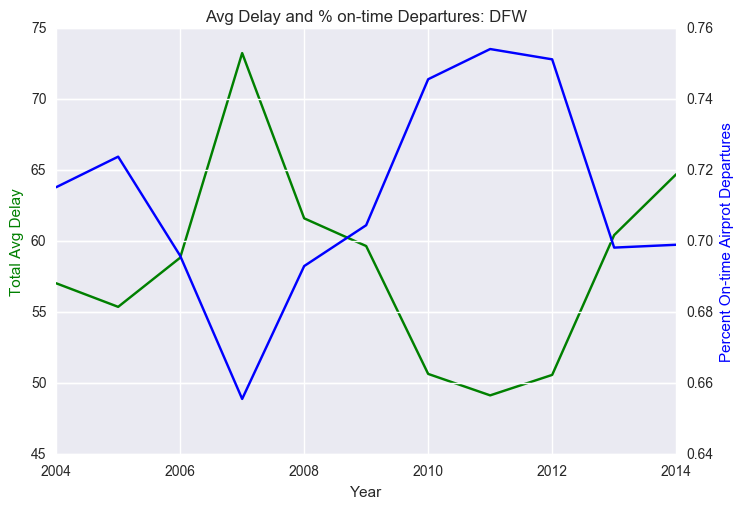

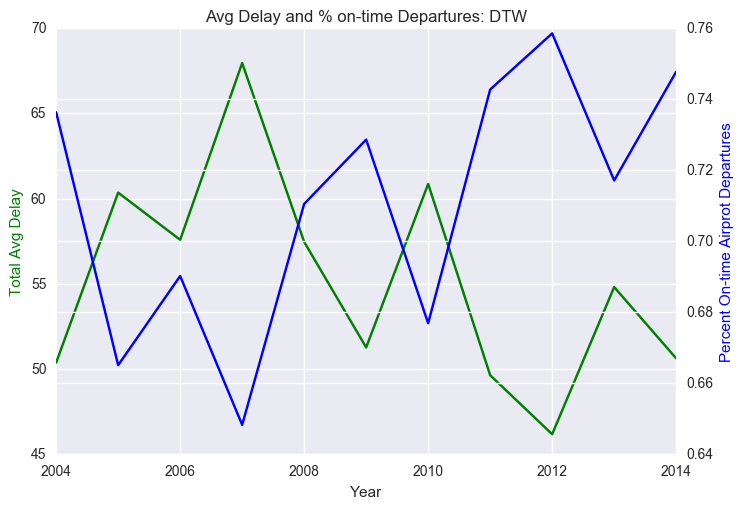

In [ ]:
for i in df_all['airport'].unique():
    curr_df = df_all[df_all['airport']==i][['Total Avg Delay', 'percent on-time airport departures', 'year']]
    x = curr_df['year']
    y1 = curr_df['Total Avg Delay']
    y2 = curr_df['percent on-time airport departures']
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'g-')
    ax2.plot(x, y2, 'b-')
    

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total Avg Delay', color='g')
    ax2.set_ylabel('Percent On-time Airprot Departures', color='b')
    
    
    plt.title("Avg Delay and % on-time Departures: " + i)
    plt.show()

In [36]:
df_all.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay', u'Airport',
       u'Year', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Key', u'LocID',
       u'AP_NAME', u'ALIAS', u'Facility Type', u'FAA REGION', u'COUNTY',
       u'CITY', u'STATE', u'AP Type', u'Latitude', u'Longitude',
       u'Boundary Data Available', u'size_label', u'size', u'Total Avg Delay'],
      dtype='object')

In [77]:
X = df_all[['year','arrivals for metric computation', 'average_gate_departure_delay', 'percent on-time gate arrivals','percent on-time airport departures','Departure Cancellations','Arrival Cancellations','FAA REGION','size']]
X = pd.get_dummies(X,columns=['size','FAA REGION'])
X_var = X.dropna()

X_var

,year,arrivals for metric computation,average_gate_departure_delay,percent on-time gate arrivals,percent on-time airport departures,Departure Cancellations,Arrival Cancellations,size_large,size_medium,size_small,size_super-size,FAA REGION_AAL,FAA REGION_ACE,FAA REGION_AEA,FAA REGION_AGL,FAA REGION_ANE,FAA REGION_ANM,FAA REGION_ASO,FAA REGION_ASW,FAA REGION_AWP
0,2004,53818,10.38,0.7921,0.7809,242.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2005,51877,9.60,0.8001,0.7922,221.0,190.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2006,51199,10.84,0.7746,0.7756,392.0,329.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2007,53611,11.29,0.7647,0.7704,366.0,304.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2008,49512,10.79,0.7875,0.7844,333.0,300.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2009,42704,9.24,0.8224,0.8147,192.0,162.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2010,42169,10.25,0.8047,0.7907,222.0,177.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2011,42297,10.81,0.8022,0.7758,345.0,294.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2012,39107,10.55,0.8177,0.7940,237.0,181.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2013,34989,12.56,0.7554,0.7402,232.0,212.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
ss = StandardScaler()
X_normalized = ss.fit_transform(X)

In [71]:
cov_mat = np.cov(X_normalized.T)

In [72]:
eig_val, eig_vec = np.linalg.eig(cov_mat)